# Model-3

In [1]:
import tensorflow as tf
import numpy as np
from dataset import Dataset
from config import get_dataset_path
from layers import *
from networks import *
from model import Model
from evaluation import build_dbase, print_accuracy, plot_search_results

In [2]:
tr_data_path  = get_dataset_path("train/5557_300_128_128_1_uint8_aug2.npy")
va_data_path  = get_dataset_path("valid/550_300_128_128_1_uint8_aug2.npy")
model_path   = "models/003/"

## Dataset

In [3]:
%%time
tr_dataset   = Dataset(tr_data_path)
va_dataset   = Dataset(va_data_path)
tr_dataset.load()
va_dataset.load()
image_shape  = list(tr_dataset.data.shape[-3:])
print("Train:", list(tr_dataset.data.shape), tr_dataset.data.dtype)
print("Valid:", list(va_dataset.data.shape), va_dataset.data.dtype)
print('-'*50)

Train: [5557, 300, 128, 128, 1] uint8
Valid: [550, 300, 128, 128, 1] uint8
--------------------------------------------------
CPU times: user 236 ms, sys: 1min 9s, total: 1min 10s
Wall time: 2min 3s


## Build 

In [4]:
%%time
out_dims       = 300
margin         = .5
acc_batch_size = 300
network        = simple_conv

# d:300 m:1 s:15k lr:1e-6 acc=87.3
# d:300 m:3 s:15k lr:1e-4 acc=93.3
# d:300 m:5 s:30k lr:1e-4 acc=97.3
# d:100 m:5 s:30k lr:1e-4 acc=

model = Model(image_shape, out_dims, acc_batch_size)
model.build(network)

CPU times: user 5.6 s, sys: 1.1 s, total: 6.7 s
Wall time: 6.81 s


In [5]:
%%time
accs = []
for i in range(10):
    acc = model.calc_acc(tr_dataset)
    accs.append(acc)
acc = np.mean(accs)
print("Acc: %.1f%%" % (acc*100))

Acc: 25.3%
CPU times: user 2.5 s, sys: 2.99 s, total: 5.49 s
Wall time: 5.33 s


## Train

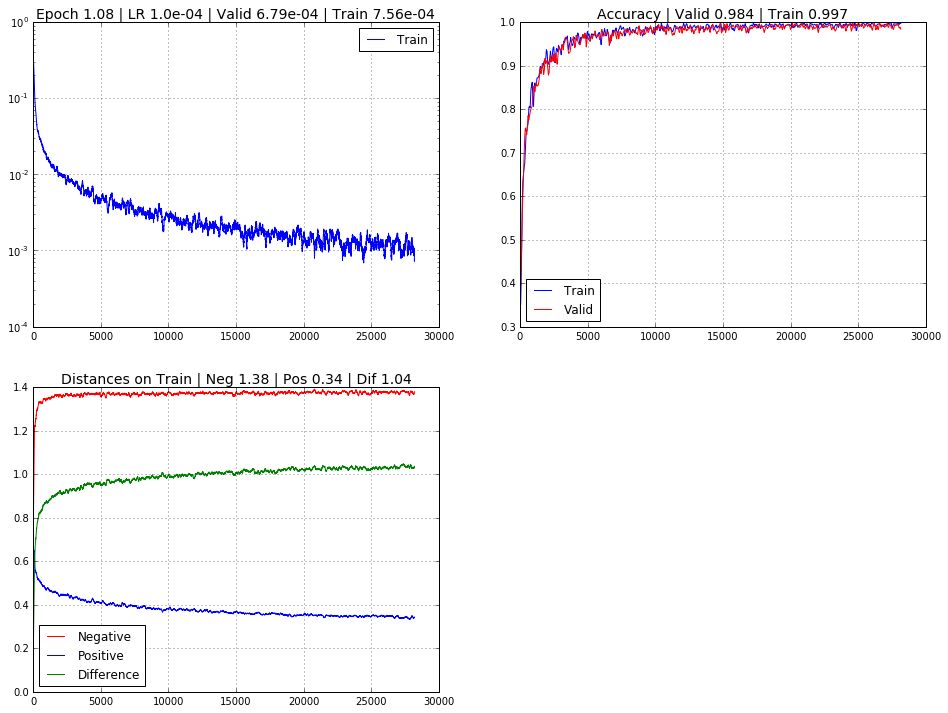

--------------------------------------------------
CPU times: user 1h 7min 22s, sys: 30min 6s, total: 1h 37min 29s
Wall time: 1h 29min 26s


In [6]:
%%time
model.train(
    step_num   = 150000, 
    batch_size = 64,
    lr         = {1:1e-4}, 
    log_every  = 50,
    tr_dataset = tr_dataset,
    va_dataset = va_dataset,
    margin     = margin,
    log_scale  = True)

model.save(model_path)
print('-'*50)

## Database

In [13]:
%%time
ethalons  = tr_dataset.get_ethalons()  # tr_dataset va_dataset
augmented = tr_dataset.get_augmented() # get_augmented() get_ethalons()

dbase     = build_dbase(model, ethalons, augmented)

Ethalons : [5557, 128, 128, 1] float32
Augmented: [5557, 128, 128, 1] float32
--------------------------------------------------
CPU times: user 1.43 s, sys: 3.91 s, total: 5.34 s
Wall time: 5.18 s


## Accuracy

In [14]:
%%time
print_accuracy(dbase, augmented, 3)

Database   : [5557, 300]
Request    : [5557, 128, 128, 1]
Performance: 277 img/sec
--------------------------------------------------
Accuracy@1: 97.3%
Accuracy@2: 98.8%
Accuracy@3: 99.2%
--------------------------------------------------
CPU times: user 20.3 s, sys: 156 ms, total: 20.5 s
Wall time: 20.1 s


## Search

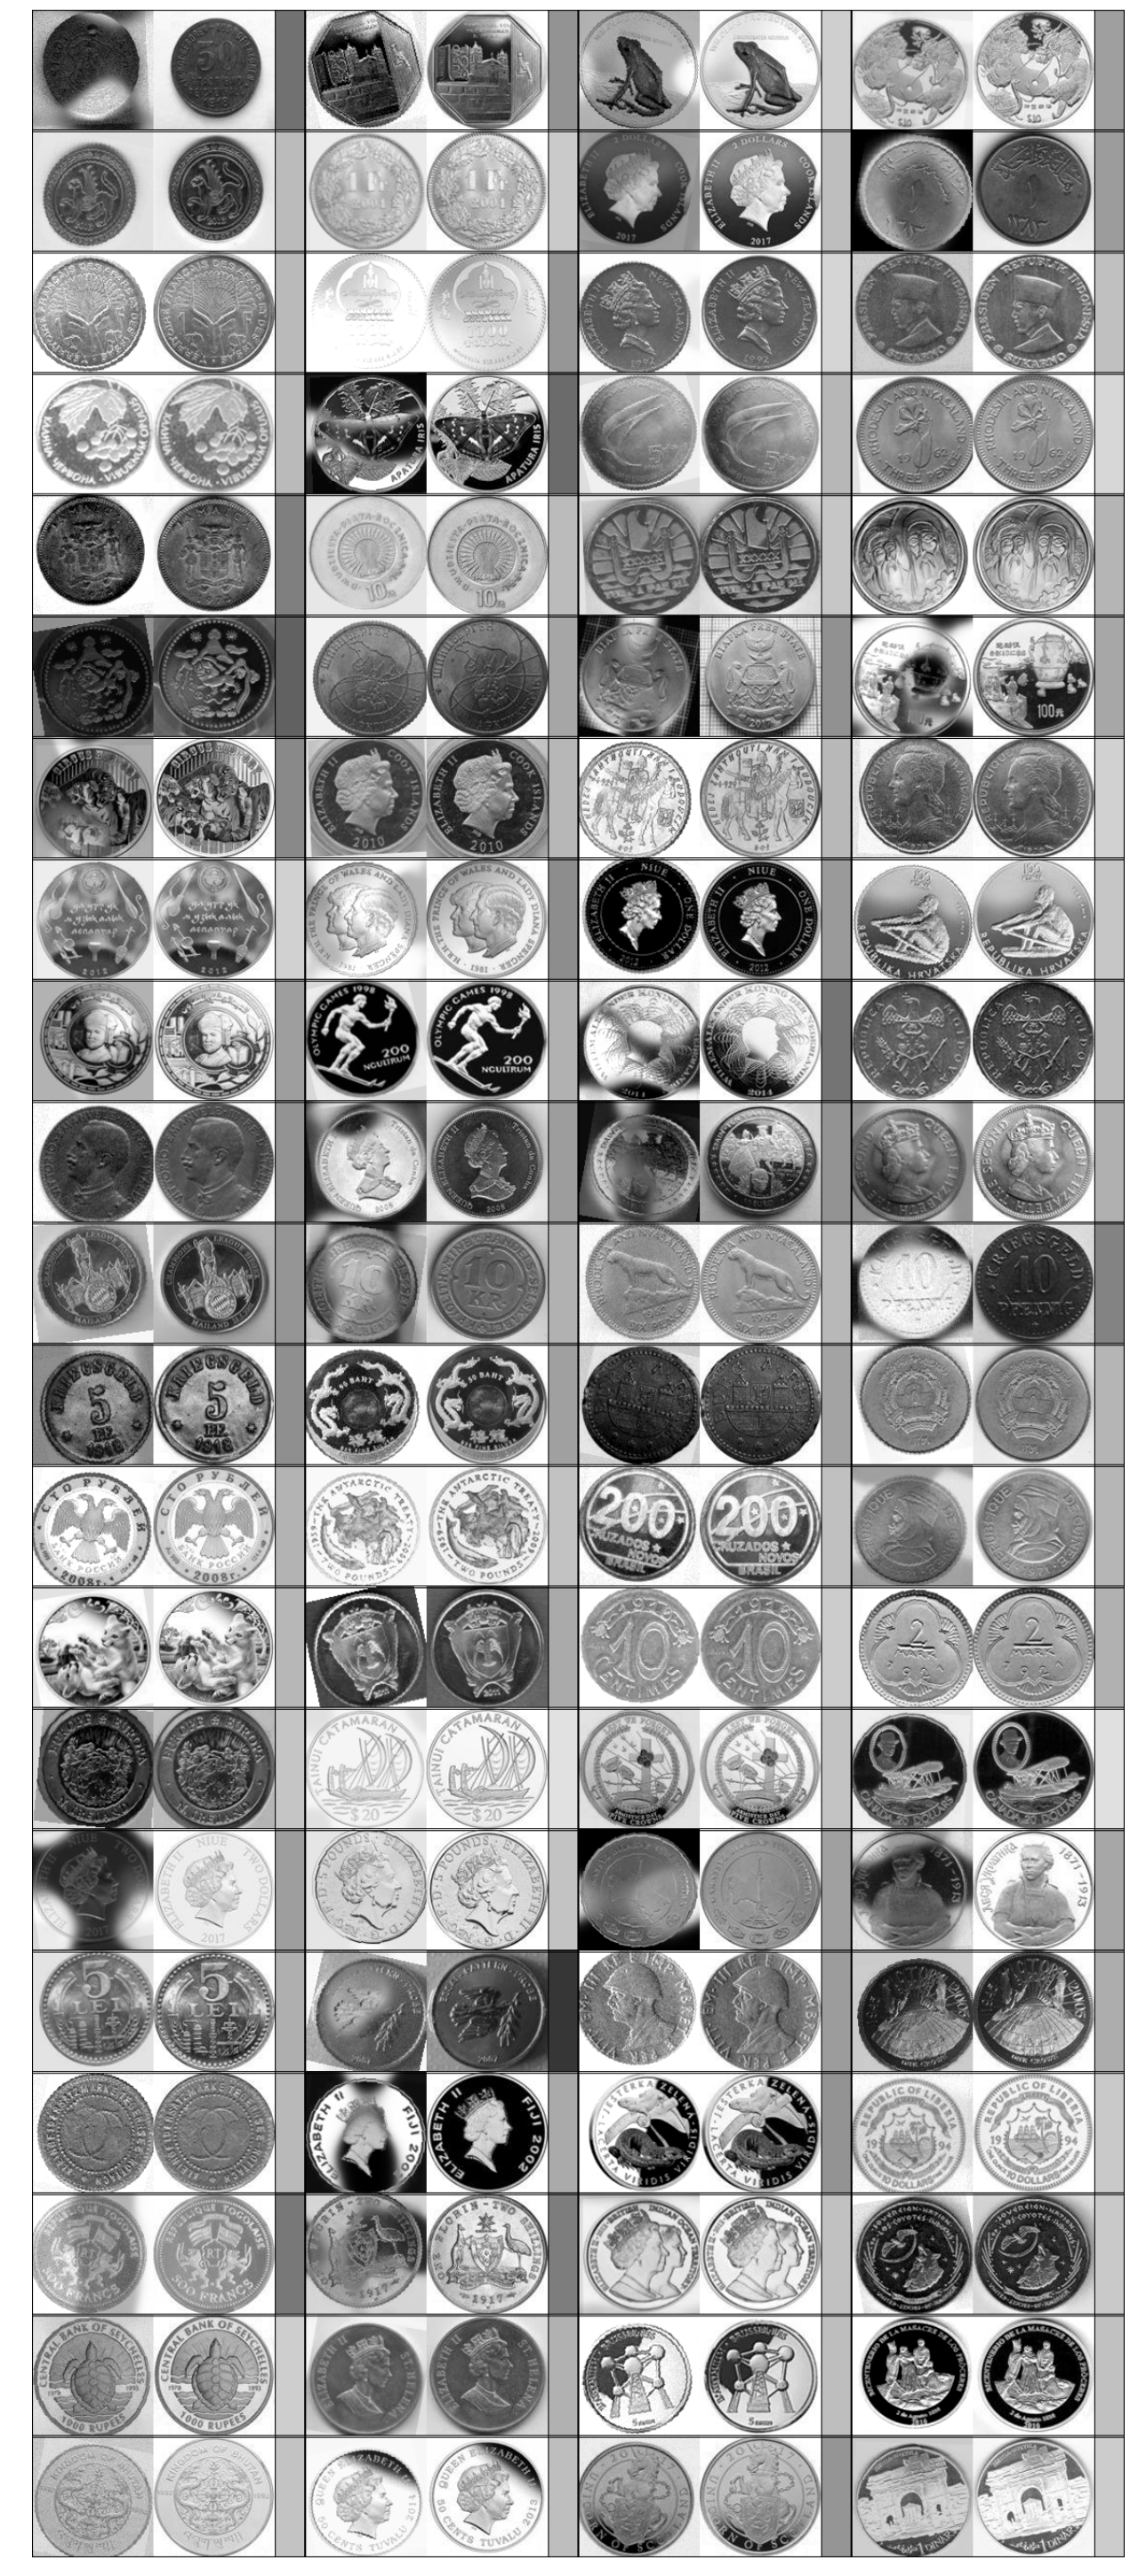

In [15]:
plot_search_results(dbase, augmented, num=84, cols=4)

## Restore

In [6]:
%time
model.restore(model_path)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.6 µs
INFO:tensorflow:Restoring parameters from models/001/
